# Mass parabolas

Source of the original code:
https://scipython.com/blog/mass-parabolas/

The code requires the 'mass.mas03' file, which contains atomic mass measurment data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 1 u = 931.49432 MeV/c2
f = 931.49432
# Hydrogen atom mass (MeV)
mH = 1.007825031898 * f
# Neutron mass (MeV)
mn = 1.008644904 * f

# Liquid drop model parameters, MeV: volume, surface and pairing terms.
aV, aS, delta = 15.75, 17.8, 11.18
# Liquid drop model parameters, MeV: asymmetry term (aA) and Coulomb term (aC).
aA, aC = 23.7, 0.711

In [3]:
def get_SEMF_mass_excess(A, Z):
    """Return the mass excess calculated using the SEMF model."""

    # The pairing term is -delta for Z and N both odd, +delta for Z and N both
    # even, and 0 otherwise. Create an array of the sign of this term so that
    # we can vectorize the calculation across the arrays Z and N.
    N = A - Z
    sgn = np.zeros(Z.shape)
    sgn[(Z%2) & (N%2)] = -1
    sgn[~(Z%2) & ~(N%2)] = +1

    # The SEMF for the binding energy.
    E = (aV*A - aS * A**(2/3) - aC * Z**2 / A**(1/3) -
         aA * (A-2*Z)**2 / A + sgn * delta / A**(1/2))

    mass_excess = Z*mH + (A-Z)*mn - A*f - E
    return mass_excess


In [4]:
def most_stable_Z(A):
    """Return the predicted most stable atomic number for mass number A."""
    Z = (4*aA - (mH - mn)) / (2*A**(-1/3) * (aC + 4*aA*A**(-2/3)))
    return round(Z)

In [5]:
# Estimated mass excesses are indicated with a '#' symbol after the numeric
# value. Drop the '#' and coerce to float, in MeV (not keV!)
strip_hash_and_keV_to_MeV = lambda s: float(s.replace('#','')) / 1000
# Read the experimental data into a Pandas DataFrame.
df = pd.read_fwf('mass.mas03', usecols=(2, 3, 4, 6, 9, 10),
              names=('N', 'Z', 'A', 'symbol', 'mass_excess', 'mass_excess_unc',
                    ),
              converters={'symbol': str,
                          'mass_excess': strip_hash_and_keV_to_MeV,
                          'mass_excess_unc': strip_hash_and_keV_to_MeV},
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

In [6]:
def get_dfA(A):
    """Return a DataFrame just for mass number A."""
    dfA = df[df['A']==A]
    return dfA

def plot_mass_parabola(A):
    dfA = get_dfA(A)
    fig, ax = plt.subplots(figsize=(8,9))
    plt.title('Mass Parabola A = {}'.format(A), fontsize=22)
    ax.errorbar(dfA['Z'], dfA['mass_excess'], dfA['mass_excess_unc'],
                marker='o', capsize=4, label='Tabulated')
    SEMF_mass_excess = get_SEMF_mass_excess(A, dfA['Z'])
    ax.plot(dfA['Z'], SEMF_mass_excess, c='tab:orange', label='SEMF')
    ax.set_xticks(dfA['Z'])
    xticklabels = [r'${}_{' + str(Z) + r'}' + r'^{' + '}\mathrm{'
                    + symbol + '}$' for Z, symbol in zip(dfA['Z'],
                                                         dfA['symbol'])]
    ax.set_xticklabels(xticklabels, fontsize=13)
    ax.set_xlabel('Nuclide', fontsize=20)
    ax.set_ylabel('Mass excess / MeV', fontsize=20)
    ax.legend()
    plt.savefig('mass_parabola_{}.png'.format(A), dpi=200)
    #plt.show()

A = 128
Predicted most stable Z = 54 (Xe)


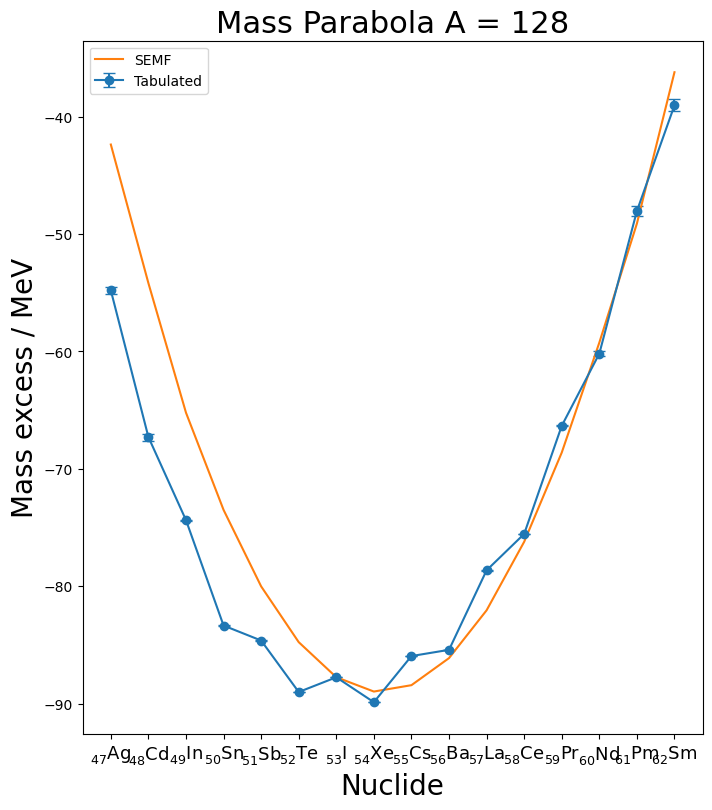

In [10]:
A = 128
stable_Z = most_stable_Z(A)
stable_symbol = df[(df['A']==A) & (df['Z']==stable_Z)].iloc[0]['symbol']
print(f'A = {A}')
print(f'Predicted most stable Z = {stable_Z} ({stable_symbol})')
plot_mass_parabola(A)